In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import pickle
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
import warnings
warnings.filterwarnings('ignore')

#### Open file

In [2]:
with open('../params.yaml') as file:
    config = yaml.safe_load(file)

In [3]:
data = pd.read_csv(config['data']['clean'])
data

,patient_id,systemic_illness,rectal_pain,sore_throat,penile_oedema,oral_lesions,solitary_lesion,swollen_tonsils,hiv_infection,sexually_transmitted_infection,monkeypox
0,P0,None,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive
3,P3,None,True,False,False,False,True,True,True,False,Positive
4,P4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive
...,...,...,...,...,...,...,...,...,...,...,...
24995,P24995,None,True,True,False,True,True,False,False,True,Positive
24996,P24996,Fever,False,True,True,False,True,True,True,True,Positive
24997,P24997,None,True,True,False,False,True,True,False,False,Positive
24998,P24998,Swollen Lymph Nodes,False,True,False,True,True,True,False,False,Negative


#### Drop column 'patient_id'

In [4]:
data = data.drop(['patient_id'], axis = 1)
data

,systemic_illness,rectal_pain,sore_throat,penile_oedema,oral_lesions,solitary_lesion,swollen_tonsils,hiv_infection,sexually_transmitted_infection,monkeypox
0,None,False,True,True,True,False,True,False,False,Negative
1,Fever,True,False,True,True,False,False,True,False,Positive
2,Fever,False,True,True,False,False,False,True,False,Positive
3,None,True,False,False,False,True,True,True,False,Positive
4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive
...,...,...,...,...,...,...,...,...,...,...
24995,None,True,True,False,True,True,False,False,True,Positive
24996,Fever,False,True,True,False,True,True,True,True,Positive
24997,None,True,True,False,False,True,True,False,False,Positive
24998,Swollen Lymph Nodes,False,True,False,True,True,True,False,False,Negative


In [5]:
data.describe(include=object).T

,count,unique,top,freq
systemic_illness,25000,4,Fever,6382
monkeypox,25000,2,Positive,15909


#### X/y split 

In [6]:
y = data['monkeypox']
X = data.drop(['monkeypox'], axis = 1)

#### Encode categorical data

In [7]:
X_bool = X.drop(['systemic_illness'], axis = 1)
X_cat = X['systemic_illness']

In [8]:
X_cat = pd.get_dummies((X_cat), drop_first=True)
X_cat

,Muscle Aches and Pain,None,Swollen Lymph Nodes
0,0,1,0
1,0,0,0
2,0,0,0
3,0,1,0
4,0,0,1
...,...,...,...
24995,0,1,0
24996,0,0,0
24997,0,1,0
24998,0,0,1


#### Concatenate categorical and boolean data again 

In [9]:
X = pd.concat([X_cat, X_bool], axis=1)
X

,Muscle Aches and Pain,None,Swollen Lymph Nodes,rectal_pain,sore_throat,penile_oedema,oral_lesions,solitary_lesion,swollen_tonsils,hiv_infection,sexually_transmitted_infection
0,0,1,0,False,True,True,True,False,True,False,False
1,0,0,0,True,False,True,True,False,False,True,False
2,0,0,0,False,True,True,False,False,False,True,False
3,0,1,0,True,False,False,False,True,True,True,False
4,0,0,1,True,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
24995,0,1,0,True,True,False,True,True,False,False,True
24996,0,0,0,False,True,True,False,True,True,True,True
24997,0,1,0,True,True,False,False,True,True,False,False
24998,0,0,1,False,True,False,True,True,True,False,False


#### Standardise column names after encoding

In [10]:
def standardize_column_names(X):
    cols = []
    for col in X.columns:
        col = col.replace(" ", "_")
        cols.append(col.lower())

    X.columns = cols
    return X

X = standardize_column_names(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   muscle_aches_and_pain           25000 non-null  uint8
 1   none                            25000 non-null  uint8
 2   swollen_lymph_nodes             25000 non-null  uint8
 3   rectal_pain                     25000 non-null  bool 
 4   sore_throat                     25000 non-null  bool 
 5   penile_oedema                   25000 non-null  bool 
 6   oral_lesions                    25000 non-null  bool 
 7   solitary_lesion                 25000 non-null  bool 
 8   swollen_tonsils                 25000 non-null  bool 
 9   hiv_infection                   25000 non-null  bool 
 10  sexually_transmitted_infection  25000 non-null  bool 
dtypes: bool(8), uint8(3)
memory usage: 268.7 KB


#### Train/test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.columns = X.columns
X_test.columns = X.columns

#### Apply StandardScaler

In [12]:
transformer = StandardScaler()
transformer.fit(X_train)

pickle.dump(transformer, open(config['scalers']['standardscaler'], 'wb'))

X_train_standardized = transformer.transform(X_train)
X_test_standardized = transformer.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_standardized, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_standardized, columns=X_test.columns)

#### Checking the target column for imbalances

In [13]:
y.value_counts()

Positive    15909
Negative     9091
Name: monkeypox, dtype: int64

##### Result: Slight imbalance in the target column ('monkeypox')

#### Upsampling the train set

In [14]:
ros = RandomOverSampler(random_state=0)
X_train_scaled_res, y_train_res = ros.fit_resample(X_train_scaled,y_train)

In [15]:
y_train_res.isna().sum()

0

In [16]:
y_train_res.value_counts()

Positive    12725
Negative    12725
Name: monkeypox, dtype: int64

#### GridSearch for RandomForestClassifier

In [17]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [2,4],
    'min_samples_split': [2,4]
}

In [18]:
gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=params, cv=5, verbose=3)
gs.fit(X_train_scaled_res, y_train_res) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END criterion=gini, min_samples_leaf=2, min_samples_split=2;, score=0.630 total time=   0.7s
[CV 2/5] END criterion=gini, min_samples_leaf=2, min_samples_split=2;, score=0.626 total time=   0.6s
[CV 3/5] END criterion=gini, min_samples_leaf=2, min_samples_split=2;, score=0.638 total time=   0.6s
[CV 4/5] END criterion=gini, min_samples_leaf=2, min_samples_split=2;, score=0.655 total time=   0.6s
[CV 5/5] END criterion=gini, min_samples_leaf=2, min_samples_split=2;, score=0.636 total time=   0.6s
[CV 1/5] END criterion=gini, min_samples_leaf=2, min_samples_split=4;, score=0.632 total time=   0.6s
[CV 2/5] END criterion=gini, min_samples_leaf=2, min_samples_split=4;, score=0.625 total time=   0.6s
[CV 3/5] END criterion=gini, min_samples_leaf=2, min_samples_split=4;, score=0.637 total time=   0.6s
[CV 4/5] END criterion=gini, min_samples_leaf=2, min_samples_split=4;, score=0.653 total time=   0.6s
[CV 5/5] END criterio

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4]},
             verbose=3)

In [19]:
gs.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 2}

##### Best Parameter: {'criterion': 'log_loss', 'min_samples_leaf': 4, 'min_samples_split': 2}


#### Best accuracy score

In [20]:
gs.best_score_

0.638664047151277

#### Best cohen-kappa score

In [21]:
y_train_pred = gs.predict(X_train_scaled_res)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.243736074028306

In [22]:
randomforest = gs.best_estimator_

#### Saving model

In [23]:
pickle.dump(gs.best_estimator_, open(config['models']['random_forest'], 'wb'))

#### Plotting confusion matrix for train set prediction

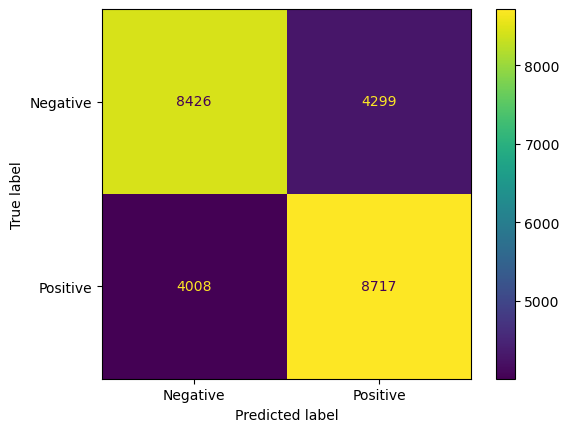

In [24]:
cm_train = confusion_matrix(y_train_res, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

#### Plot confusion matrix for test set prediction

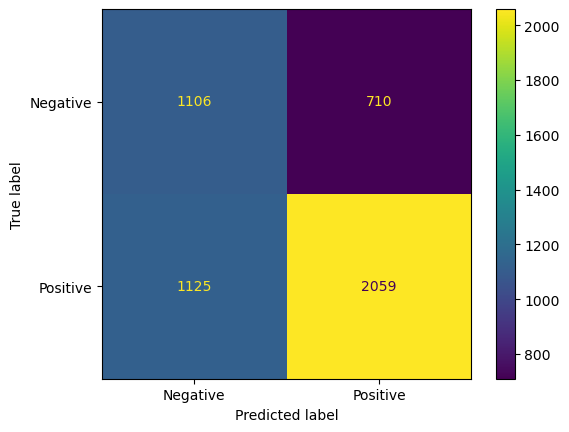

In [25]:
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [26]:
results = cross_val_score(gs.best_estimator_, X_train_scaled_res, y_train_res, cv=5)
print(f"Average accuracy on the train set: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy on the test set: {results.mean()}")

Average accuracy on the train set: 0.6370530451866405
Average accuracy on the test set: 0.6698000000000001


#### GridSearch for KNN-Classifier

In [27]:
params = {
    'n_neighbors': [3, 5, 8, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, verbose=3)
gs.fit(X_train_scaled_res, y_train_res)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.571 total time=   0.3s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.586 total time=   0.3s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.577 total time=   0.3s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.602 total time=   0.3s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.588 total time=   0.3s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.571 total time=   0.2s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.586 total time=   0.2s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.577 total time=   0.2s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.602 total time=   0.2s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.588 total time=   0.2s
[CV

[CV 1/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=0.571 total time=   0.2s
[CV 2/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=0.586 total time=   0.2s
[CV 3/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=0.577 total time=   0.2s
[CV 4/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=0.602 total time=   0.2s
[CV 5/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=0.588 total time=   0.2s
[CV 1/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.581 total time=   0.3s
[CV 2/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.603 total time=   0.3s
[CV 3/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.587 total time=   0.3s
[CV 4/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.613 total time=   0.3s
[CV 5/5] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.600 total time=   0.3s
[CV 1/5] END algorithm=kd_tree, n_n

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 8, 10],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [28]:
gs.best_params_

{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'uniform'}

##### Best parameters: {'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'uniform'}

#### Best accuracy score

In [29]:
gs.best_score_

0.6169744597249508

#### Best cohen-kappa score

In [30]:
y_train_pred = gs.predict(X_train_scaled_res)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.2169587544630256

In [31]:
knn = gs.best_estimator_

#### Saving model

In [32]:
pickle.dump(gs.best_estimator_, open(config['models']['knn'], 'wb'))

#### Plotting confusion matrix for train set prediction

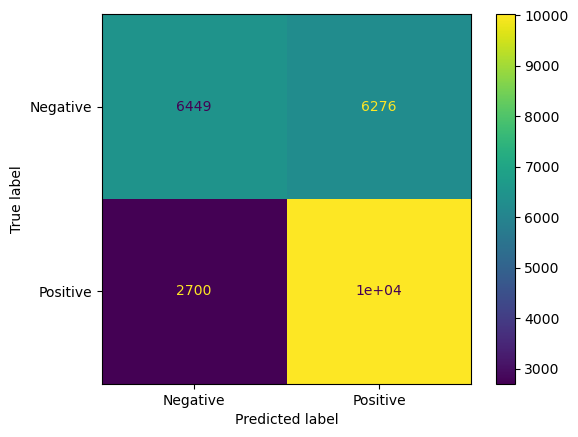

In [33]:
cm_train = confusion_matrix(y_train_res, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

#### Plotting confusion matrix for test set prediction

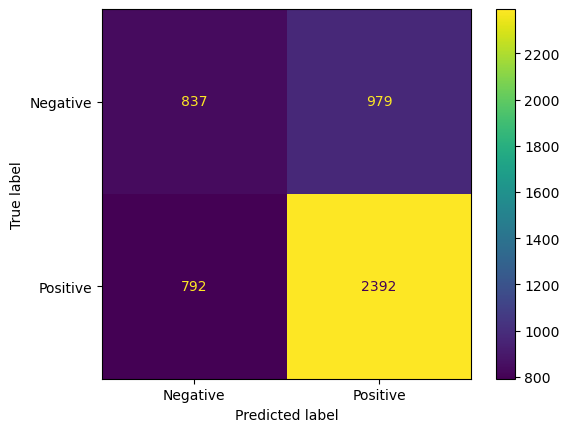

In [34]:
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [35]:
results = cross_val_score(gs.best_estimator_, X_train_scaled_res, y_train_res, cv=5)
print(f"Average accuracy on the train set: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy on the test set: {results.mean()}")

Average accuracy on the train set: 0.6169744597249508
Average accuracy on the test set: 0.6355999999999999


#### GridSearch for LogisticRegression

In [36]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [300]
}

gs = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5)
gs.fit(X_train_scaled_res, y_train_res)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']})

In [37]:
gs.best_params_

{'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}

##### Best parameters: {'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}

#### Best accuracy score

In [38]:
gs.best_score_

0.6412966601178782

#### Best cohen-kappa score

In [39]:
y_train_pred = gs.predict(X_train_scaled_res)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.282259864425782

In [40]:
logisticreg = gs.best_estimator_

#### Saving model

In [41]:
pickle.dump(gs.best_estimator_, open(config['models']['logistic_regression'], 'wb'))

#### Plotting confusion matrix for train set prediction

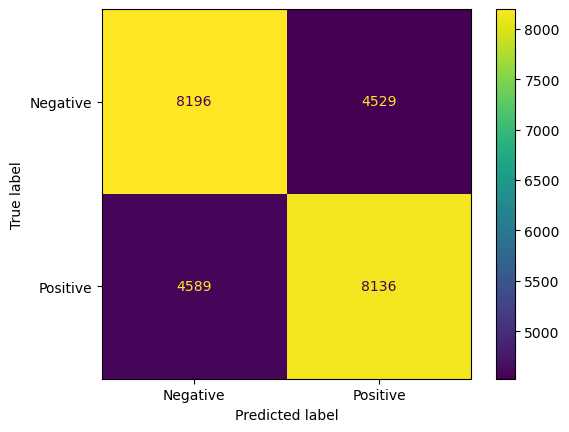

In [42]:
cm_train = confusion_matrix(y_train_res, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

#### Plotting confusion matrix for test set prediction

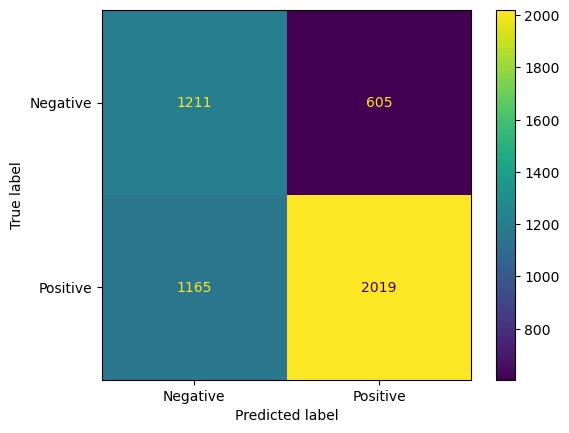

In [43]:
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [44]:
results = cross_val_score(gs.best_estimator_, X_train_scaled_res, y_train_res, cv=5)
print(f"Average accuracy on the train set: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy on the test set: {results.mean()}")

Average accuracy on the train set: 0.6412966601178782
Average accuracy on the test set: 0.7008


#### Plotting the receiver operating characteristic (ROC) curve



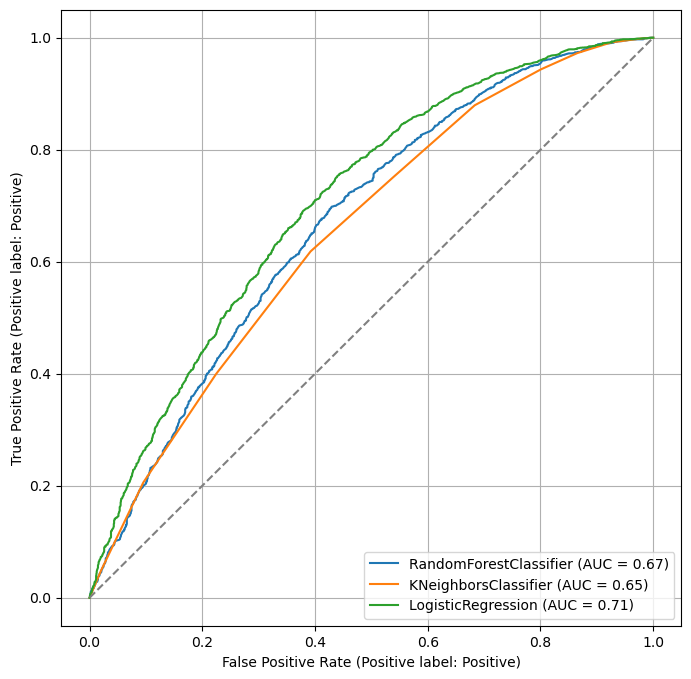

In [45]:
fig,ax = plt.subplots(figsize=(8,8))
plot_roc_curve(randomforest, X_test_scaled, y_test, ax=ax)
plot_roc_curve(knn, X_test_scaled, y_test, ax=ax)
plot_roc_curve(logisticreg, X_test_scaled, y_test, ax=ax)
plt.plot([0,1], [0,1], linestyle='dashed', color='grey')
ax.grid()
plt.savefig('../plots/roc_curves.png', dpi=300)
plt.show()